# Model estimation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from random import shuffle
import sys,os, pickle, jellyfish
from collections import defaultdict
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.pooling import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.utils.np_utils import to_categorical
from keras import optimizers


# ------------------------ helper functions -------------------------- #

def get_parent_dir(directory):
    '''Returns the parent directory of the current one'''
    return os.path.dirname(directory)


# ------------------------ functions for processing the text ---------- #
def make_digit(word):
    '''Transforms string labels to digits'''
    if word == 'negative':
        return int(0)
    elif word == 'neutral':
        return int(1)
    elif word == 'positive':
        return int(2)
    else:
        '{} is neither positive, neutral or negative'.format(word)
        
        
        
        
def get_word_ids(sentence, vocabulary):
    '''Returns index in the vocabulary for each word of the sentence.'''
    words = text.text_to_word_sequence(sentence)
    return [vocabulary.index(x) if x in vocabulary else len(vocabulary) for x in words]

current_dirs_parent = get_parent_dir(os.getcwd())

Using TensorFlow backend.


### read in vocabulary and word-vector files

In [2]:
vocabulary = []
occurrences = {}

with open('/Users/lisabarcelo/Desktop/W266/food_drug_interaction/BioNLP/ri-3gram-400-tsv/vocab.tsv') as vocabulary_file:
    for line in vocabulary_file:
        word, occurrence = line.strip().split('\t')
        vocabulary.append(word)
        occurrences[word] = occurrence

print(len(vocabulary))

4929266


In [ ]:
embeddings_index = {}
with open('/Users/lisabarcelo/Desktop/W266/food_drug_interaction/BioNLP/ri-3gram-400-tsv/vectors.tsv') as embedding_file:
    for i, line in enumerate(embedding_file):
        values = line.strip().split('\t')
        vector = np.asarray(values, dtype='float32')
        embeddings_index[vocabulary[i]] = vector

In [9]:
#pickle.dump(embeddings_index, open('/media/adam/Data/BioNLP/embeddings_index.pickle','wb'))
#embeddings_index = pickle.load(open('/media/adam/Data/BioNLP/embeddings_index.pickle','rb'))

### Read-in compounds in order to add them to vocabulary

In [10]:
compounds = Counter()

       
with open(current_dirs_parent + '/data/labeled_dataAll.tsv', 'r') as labelled_sents: 
    for num, line in enumerate(labelled_sents):
        _,label,_,_,compound, sent = line.strip().split('\t')
        compounds[compound] += 1
        # here we could canonicalize


In [ ]:
print(compounds.most_common(10))
len(compounds)

### pre-trained embeddings for the compounds

If there is more than one alternative (alternative specified by JW distance > .95), than take weighted average of the word vectors, weighted by number of occurences of the compound in the corpus.

In [5]:
i = 0
compound_index = {}
for compound in compounds:
    # the word vectors are 400 long
    compound_embedding = np.zeros(400)
    num_alternatives = 0
    occurrence_total = 0
    for i, word in enumerate(vocabulary):
        # take weighted average (element-wise) of the word vectors, weighted by the occurrences of the compound in corpus
        if jellyfish.jaro_winkler(compound, word) > 0.95:
            compound_embedding += embeddings_index[word]*int(occurrences[word])
            num_alternatives += 1
            occurrence_total += int(occurrences[word])
            
    compound_index[compound] = compound_embedding/(num_alternatives*occurrence_total)


In [11]:
#pickle.dump(compound_index, open('/media/adam/Data/BioNLP/compound_index.pickle','wb'))
compound_index = pickle.load(open('/media/adam/Data/BioNLP/compound_index.pickle','rb'))

Should have paid more attention to zero division above, rewrite the vectors to 0s if they are np.nans 

In [12]:
temp_compounds = {}
for k,v in compound_index.items():
    if any(np.isnan(v)):
        continue
    temp_compounds[k] = v
len(temp_compounds)

693

Before finding alternative spellings, there were 581 compounds found of our 886, after JW distance alternatives, we have 693. As it doesn't take much time and improves visibility, in another step, let's take out those compounds which are in the top 20k of the vocabulary.

In [16]:
V = 20000
j = 0
final_compounds = {}
for compound, vector in temp_compounds.items():
    if compound not in vocabulary[:V]:
        final_compounds[compound] = vector
# top 20k words, remaining compounds not in the top 20k, and one extra line for the unknown words        
V_total = V + len(final_compounds) + 1

In [17]:
V_total

20554

### Prepare embedding matrix

In [22]:
dim = 400

vocab_final = []
embedding_matrix = np.zeros((V, dim))
for i, word in enumerate(vocabulary[:V]):
    embedding_matrix[i] = embeddings_index[word]
    vocab_final.append(word)

    
final_compound_matrix = np.zeros((len(final_compounds), dim))
for i, item in enumerate(final_compounds.items()):
    compound, vector = item
    final_compound_matrix[i] = vector
    vocab_final.append(compound)

# stack top 20k words, compounds not found among the 20k words and a
# vector of zeros for the words not in the vocabulary    
embedding_matrix = np.vstack([embedding_matrix, final_compound_matrix, np.zeros(dim)])
assert embedding_matrix.shape == (V_total, dim)

In [ ]:
'honey' in temp_compounds.keys()

### Prepare sentences for analysis
Most importantly, change the words in the sentences to indeces corresponding to the rows of the embedding matrix.

Bootstrap positive and negative sentences to balance the label distribution.

In [20]:
df = pd.read_csv(current_dirs_parent + '/data/labeled_dataAll.tsv', index_col='ID', sep='\t')
df.head(5)

,Label_alpha,Label_num,Drug,Food,sentence
ID,,,,,
400,neutral,1,ACE inhibitor,pentadecanoic acid,(123)iodine labelled beta-methyl-iodophenyl pe...
333,positive,2,ACE inhibitor,2-phenylethanol,2-Phenylethanol is a widely used aroma compoun...
77,positive,2,ACE inhibitor,"3,4-dihydroxyphenylacetic acid","3,4-dihydroxyphenylacetic acid and 4-methylcat..."
338,neutral,1,ACE inhibitor,arachin,A 96-well microplate format of this method was...
214,neutral,1,ACE inhibitor,diethylamine,A biochemical study was performed in order to ...


In [23]:
labels = defaultdict(list)
sent_classified = list()
sentences = defaultdict(list)
sent_label = list()
max_sentence_length = 0
num = 0

for index, row in df.iterrows():
    sentence = row['sentence']
    # include only those compounds that are found in the corpus
    if row['Food'] in temp_compounds.keys():
        labels[num] = row['Label_alpha']
        sentences[num] = sentence.lower()
        num += 1
        sent = text.text_to_word_sequence(sentence)          
        try:
            sent_label.append(row['Label_num'])
            max_sentence_length = np.max([max_sentence_length, len(sent)])
            sent_classified.append(get_word_ids(sentence, vocab_final))
        except KeyError:
            pass

In [24]:
len(sentences)

1920

/home/adam/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


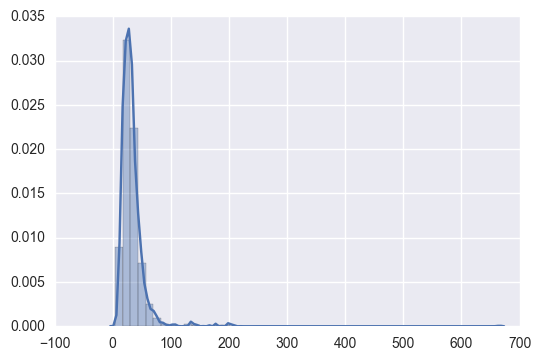

In [25]:
%matplotlib inline
sentence_length = []
for sentence in sentences.values():
    sentence_length.append(len(sentence.split(' ')))
sns.distplot(sentence_length)

## Trainable parameters/settings

In [1]:
LSTM_UNITS = 300
NUM_EPOCHS = 100
DROPOUT_RATE = 0.2
MAX_SENTENCE_LENGTH = 100
optim = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#optim = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# change vocabulary size? maybe 20k is too much?

NameError: name 'optimizers' is not defined

### Fit model

Here I pad the sentences to max sentence length but maybe we could truncate?

In [ ]:
ids = list(range(len(sentences)))
shuffle(ids)
P_TRAIN = .75
N_TRAIN = int(round(P_TRAIN * len(sent_label),0))
train_ids = ids[:N_TRAIN]
test_ids = ids[(N_TRAIN + 1):]
train_sents, train_labels = zip(*[(sent_classified[train_id], sent_label[train_id]) for train_id in train_ids])
test_sents, test_labels = zip(*[(sent_classified[test_id], sent_label[test_id]) for test_id in test_ids])

# add padding so that all of the sentences have the same length
train_sents = sequence.pad_sequences(train_sents, maxlen=MAX_SENTENCE_LENGTH)
test_sents = sequence.pad_sequences(test_sents, maxlen=MAX_SENTENCE_LENGTH)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# create the model
model = Sequential()
model.add(Embedding(V_total, dim, weights=[embedding_matrix],
                    input_length=MAX_SENTENCE_LENGTH, trainable=False))
model.add(LSTM(LSTM_UNITS, return_sequences = True))
model.add(Dropout(DROPOUT_RATE))
model.add(LSTM(LSTM_UNITS))
model.add(Dropout(DROPOUT_RATE))
#model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid'))
model.add(Dense(3, activation='softmax'))


# Compile model
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['categorical_accuracy'])
print(model.summary())

# Final evaluation of the model
model.fit(train_sents, train_labels, epochs=NUM_EPOCHS, batch_size=32)
scores = model.evaluate(test_sents, test_labels, verbose=0)
print("Test accuracy: {}".format(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 400)          8221600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 300)          841200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 300)          721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total para

In [ ]:
scores = model.evaluate(test_sents, test_labels, verbose=1)
print("Test accuracy: {}".format(scores[1]*100))

In [ ]:
testing_prediction = model.predict(test_sents)
training_prediction = model.predict(train_sents)

In [ ]:
pickle.dump(testing_prediction, open('lstm_1x_300_dropout_02_lr_001_epoch_100_testing_V_30k_not_trainable_embed_75_sent.pickle','wb'))
pickle.dump(training_prediction, open('lstm_1x_300_dropout_02_lr_001_epoch_100_training_V_30k_not_trainable_embed_75_sent.pickle','wb'))

In [ ]:
pred_classes = np.argmax(testing_prediction, axis = 1)
p = 0
neu = 0
neg = 0
for i in pred_classes:
    if i == 0:
        neg += 1
    elif i == 1:
        neu += 1
    else:
        p += 1

In [ ]:
[p,neu,neg]

In [ ]:
true_classes = np.argmax(test_labels, axis=1)
p = 0
neu = 0
neg = 0
for i in true_classes:
    if i == 0:
        neg += 1
    elif i == 1:
        neu += 1
    else:
        p += 1

In [ ]:
[p, neu, neg]

In [ ]:
with open('pred_true_final.csv','w') as outfile:
    for i in range(len(true_classes)):
        if i == 0:
            print('true,predicted', file=outfile)
        print('{0},{1}'.format(true_classes[i],pred_classes[i]), file=outfile)

In [ ]:
!pwd